# **SMAI Assignment - 1**
##### (Monsoon 2023-24)

> **Name**: *Bhav Beri*
> 
> **Roll Number**: *2021111013*

#### Imports

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
from itertools import chain, combinations

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, multilabel_confusion_matrix

#### Configs

In [182]:
dataset_path = "../advertisement.csv"
k_splits = 5
random_state = 42

In [183]:
possible_criterion = ["gini", "entropy"]
possible_max_depth = [3,5,10,20,30]
possible_max_features = [3,5,7,9,11]

#### Utils

In [184]:
def encode_columns(df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder().fit(df[col])
        df[col] = le.transform(df[col])
        encoders[col] = le
    return df, encoders

In [185]:
def get_unique_labels(df_column):
    s = set()
    labels = list(map(lambda x: x.split(), df_column))
    for label in labels:
        s.update(label)
    return list(s)

In [186]:
def getDifference(a,p):
    symmetric_diff = []

    for row1, row2 in zip(a,p):
        diff_row = list(set(row1).symmetric_difference(row2))
        symmetric_diff.append(diff_row)

    return sum(len(sublist)/len(a) for sublist in symmetric_diff)

In [187]:
def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

In [188]:
def decimalListToBinaryList(l):
    result = []
    for i in l:
        s = bin(i).replace("0b", "")
        s = "0"*(8-len(s))+s
        result.append(list(map(int,list(s))))
    return result


In [189]:
class DT_Powerset():
    def __init__(self, all_labels, max_depth=None, max_features=None, criterion="gini"):
        assert criterion in possible_criterion
        
        self.data = None
        self.labels = None

        self.all_labels = get_unique_labels(all_labels)
        powerset_labels = list(map(lambda x: " ".join(sorted(x)), powerset(self.all_labels)))
        self.label_encoder = LabelEncoder().fit(powerset_labels)

        self.dt = dtc(max_depth=max_depth, max_features=max_features, criterion=criterion)

    def encode_labels(self, labels):
        labels = list(map(lambda x: " ".join(sorted(x.split())), labels))
        return self.label_encoder.transform(labels)
    
    def decode_labels(self, labels):
        return self.label_encoder.inverse_transform(labels)
    
    def fit(self, data, labels):
        assert data.shape[0] == labels.shape[0]

        self.data = np.array(data)
        self.labels = self.encode_labels(labels)
        self.dt.fit(self.data, self.labels)

    def predict(self, data):
        data = np.array(data)
        return self.decode_labels(self.dt.predict(data))
    
    def scoring(self, actual_labels, pred_labels):
        actual_labels = list(actual_labels)
        pred_labels = list(pred_labels)
        
        pred_labels = list(map(lambda x: " ".join(sorted(x.split())), pred_labels))

        accuracy_macro = sum(np.array(actual_labels) == np.array(pred_labels)) / len(actual_labels)

        actual_labels = decimalListToBinaryList(self.encode_labels(actual_labels))
        pred_labels = decimalListToBinaryList(self.encode_labels(pred_labels))
        accuracy_micro = 1-hamming_loss(actual_labels, pred_labels)

        f1_micro = f1_score(actual_labels, pred_labels, average="micro")
        f1_macro = f1_score(actual_labels, pred_labels, average="macro")

        precision_score_micro = precision_score(actual_labels, pred_labels, average="micro", zero_division=0)
        precision_score_macro = precision_score(actual_labels, pred_labels, average="macro", zero_division=0)

        recall_score_micro = recall_score(actual_labels, pred_labels, average="micro", zero_division=0)
        recall_score_macro = recall_score(actual_labels, pred_labels, average="macro", zero_division=0)

        cf_matrix = multilabel_confusion_matrix(actual_labels, pred_labels)

        scores = {
            "accuracy_micro": accuracy_micro,
            "accuracy_macro": accuracy_macro,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "precision_score_micro": precision_score_micro,
            "precision_score_macro": precision_score_macro,
            "recall_score_micro": recall_score_micro,
            "recall_score_macro": recall_score_macro,
            "cf_matrix": cf_matrix
        }

        return scores

In [190]:
class DT_MultiOutput():
    def __init__(self, all_labels, max_depth=None, max_features=None, criterion="gini"):
        assert criterion in ["gini", "entropy"]
        
        self.data = None
        self.labels = None

        self.all_labels = get_unique_labels(all_labels)
        self.label_encoder = MultiLabelBinarizer().fit([self.all_labels,])

        self.dts = {}
        for label in self.all_labels:
            self.dts[label] = dtc(max_depth=max_depth, max_features=max_features, criterion=criterion)

    def encode_labels(self, labels):        
        labels = list(map(lambda x: x.split(), labels))
        return self.label_encoder.transform(labels)
    
    def decode_labels(self, labels):
        labels = np.array(labels)
        return list(self.label_encoder.inverse_transform(labels))
    
    def fit(self, data, labels):
        assert data.shape[0] == labels.shape[0]

        self.data = data
        self.labels = self.encode_labels(labels)

        for i, label in enumerate(self.all_labels):
            self.dts[label].fit(self.data, self.labels[:,i])

    def predict(self, data):
        pred_labels = []
        for i, label in enumerate(self.all_labels):
            pred_labels.append(np.array(self.dts[label].predict(data)))
        
        pred_labels = np.array(pred_labels).T

        return self.decode_labels(pred_labels)
    
    def scoring(self, actual_labels, pred_labels):
        actual_labels = list(actual_labels)
        pred_labels = list(pred_labels)
        pred_labels = list(map(lambda x: " ".join(sorted(x)), pred_labels))

        accuracy_macro = sum(np.array(actual_labels) == np.array(pred_labels)) / len(actual_labels)

        actual_labels = self.encode_labels(actual_labels)
        pred_labels = self.encode_labels(pred_labels)

        accuracy_micro = 1-hamming_loss(actual_labels, pred_labels)

        f1_micro = f1_score(actual_labels, pred_labels, average="micro")
        f1_macro = f1_score(actual_labels, pred_labels, average="macro")

        precision_score_micro = precision_score(actual_labels, pred_labels, average="micro", zero_division=0)
        precision_score_macro = precision_score(actual_labels, pred_labels, average="macro", zero_division=0)

        recall_score_micro = recall_score(actual_labels, pred_labels, average="micro", zero_division=0)
        recall_score_macro = recall_score(actual_labels, pred_labels, average="macro", zero_division=0)

        cf_matrix = multilabel_confusion_matrix(actual_labels, pred_labels)

        scores = {
            "accuracy_micro": accuracy_micro,
            "accuracy_macro": accuracy_macro,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "precision_score_micro": precision_score_micro,
            "precision_score_macro": precision_score_macro,
            "recall_score_micro": recall_score_micro,
            "recall_score_macro": recall_score_macro,
            "cf_matrix": cf_matrix
        }

        return scores

#### Main Code

In [191]:
dataset=pd.read_csv(dataset_path)

In [192]:
print(dataset.shape, dataset.size)

(1000, 11) 11000


In [193]:
# Dataset Sample Values
print(dataset.head())

   age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False         0  Williamshaven   
4   29  Female  44792.627094       Master    False         0       New Paul   

    occupation  purchase_amount most bought item  \
0       Doctor        87.697118          monitor   
1  Businessman       115.135586         lipstick   
2     Engineer       101.694559         biscuits   
3       Lawyer        97.964887            maggi   
4  Businessman        86.847281           carpet   

                             labels  
0       electronics clothing sports  
1                  furniture beauty  
2  clothing electronics food sports  
3                              food  
4                     

In [194]:
print(dataset.describe())
print(dataset.info())

               age        income     children  purchase_amount
count  1000.000000   1000.000000  1000.000000      1000.000000
mean     40.836000  49349.796167     1.508000       101.098170
std      13.786848   9894.479148     1.129253        20.348736
min      18.000000  21908.867759     0.000000        23.482179
25%      28.000000  42577.352034     0.000000        87.699577
50%      41.000000  48993.757137     1.000000       101.587560
75%      53.000000  56566.795992     3.000000       114.718926
max      64.000000  79459.294416     3.000000       168.978628
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool  

In [195]:
print("Education Values:", len(dataset['education'].unique()))
print(dataset['education'].value_counts())
print("City Values:", len(dataset['city'].unique()))
print("Occupaion Values:", len(dataset['occupation'].unique()))
print(dataset['occupation'].value_counts())
print("Most Bought items:", len(dataset['most bought item'].unique()))
print("Labels:", len(dataset['labels'].unique()))

Education Values: 4
education
Master         269
PhD            252
High School    240
Bachelor       239
Name: count, dtype: int64
City Values: 969
Occupaion Values: 11
occupation
Scientist      104
HR             102
Lawyer          95
Unemployed      95
Businessman     93
Engineer        91
Artist          88
Retired         88
Salesman        85
Housewife       82
Doctor          77
Name: count, dtype: int64
Most Bought items: 24
Labels: 397


Columns of the dataset are as follows:

1. age - int
2. gender - Male/Female
3. income - float
4. education - string
5. married - True/False
6. children - int
7. city - string
8. occupation - string
9. purchase_amount - float
10. most bought item - string
- labels - string (Multi-class classification)

In [196]:
colums_to_encode = ['gender', 'married', "education", "occupation", "city", "most bought item"]
dataset_copy = dataset.copy(deep=True)
encoded_data, encoders = encode_columns(dataset_copy, colums_to_encode)
encoded_data.drop(['labels'], axis=1, inplace=True)

In [197]:
print(encoded_data.head())

   age  gender        income  education  married  children  city  occupation  \
0   45       1  61271.953359          2        0         3   366           2   
1   24       0  53229.101074          1        0         1    98           1   
2   45       0  30066.046684          0        1         3   403           3   
3   19       1  48950.246384          3        0         0   959           6   
4   29       0  44792.627094          2        0         0   521           1   

   purchase_amount  most bought item  
0        87.697118                16  
1       115.135586                13  
2       101.694559                 3  
3        97.964887                14  
4        86.847281                 4  


In [198]:
X_train, X_test, y_train, y_test = train_test_split(encoded_data, dataset['labels'], test_size=0.2, random_state=random_state)

In [199]:
# dt = DT_Powerset(dataset['labels'], max_depth=3, max_features=3, criterion="gini")
# dt.fit(X_train, y_train)
# y_pred = dt.predict(X_test)
# scores = dt.scoring(y_test, y_pred)
# print(scores)

In [200]:
# dt = DT_MultiOutput(dataset['labels'], max_depth=3, max_features=3, criterion="gini")
# dt.fit(X_train, y_train)

# y_pred = dt.predict(X_test)
# scores = dt.scoring(y_test, y_pred)
# print(scores)

In [201]:
all_scores_powerset = []
all_scores_multioutput = []

for criterion in possible_criterion:
    for max_depth in possible_max_depth:
        for max_features in possible_max_features:
            dt = DT_Powerset(dataset['labels'], max_depth=max_depth, max_features=max_features, criterion=criterion)
            dt.fit(X_train, y_train)
            score = dt.scoring(y_test, dt.predict(X_test))
            all_scores_powerset.append([criterion, max_depth, max_features, score])

            dt = DT_MultiOutput(dataset['labels'], max_depth=max_depth, max_features=max_features, criterion=criterion)
            dt.fit(X_train, y_train)
            score = dt.scoring(y_test, dt.predict(X_test))
            all_scores_multioutput.append([criterion, max_depth, max_features, score])

In [202]:
# Sort as per F1 scores

all_scores_multioutput = sorted(all_scores_multioutput, key=lambda x: x[3]["f1_micro"], reverse=True)
all_scores_powerset = sorted(all_scores_powerset, key=lambda x: x[3]["f1_micro"], reverse=True)

In [203]:
pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_powerset:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

+-----------+-----------+--------------+--------------------+----------+--------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |       F1 Macro      | Precision Score Micro | Precision Score Macro |  Recall Score Micro |  Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
|  entropy  |     5     |      11      | 0.6325000000000001 |   0.09   | 0.6632302405498283 |  0.6366725808222504 |   0.6835891381345927  |   0.6633225993502109  |  0.6440489432703004 |   0.61798207946333  |
|  entropy  |     10    |      9       |        0.61        |   0.02   | 0.6529477196885428 |  0.6374959654350337 |   0.6529477196885428  |   0.637188024551624   |  0.6

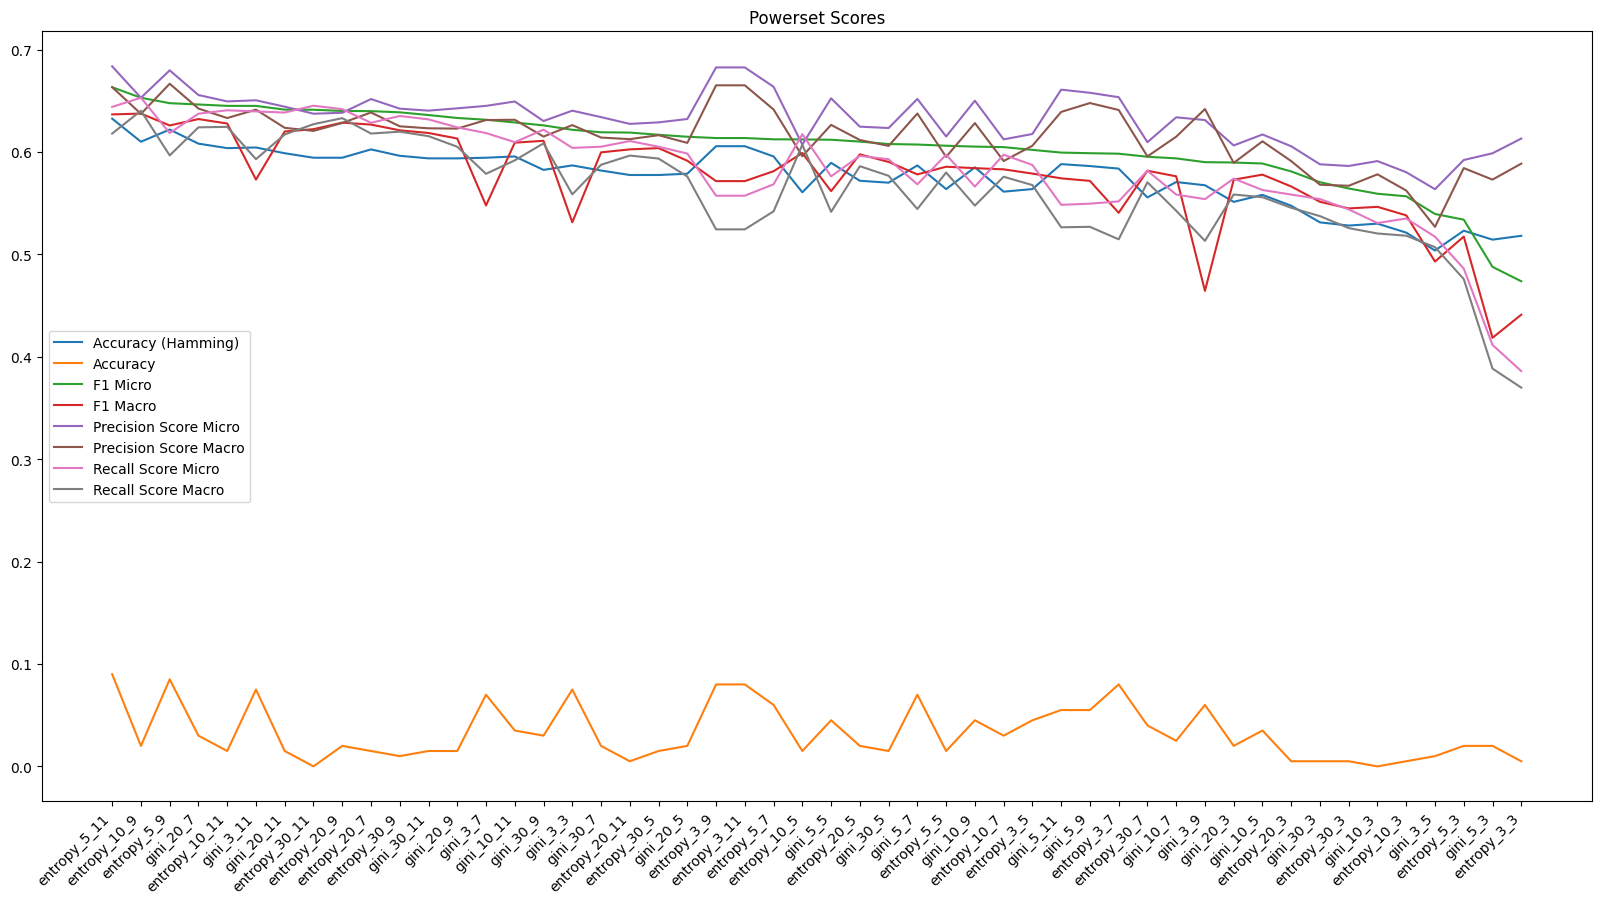

In [204]:
# Plot a graph will all these parameters of scores

x_axis = list(map(lambda x: x[0] + "_" + str(x[1]) + "_" + str(x[2]), all_scores_powerset))

plt.figure(figsize=(20,10))
plt.title("Powerset Scores")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_micro"], all_scores_powerset)), label="Accuracy (Hamming)")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_macro"], all_scores_powerset)), label="Accuracy")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_micro"], all_scores_powerset)), label="F1 Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_macro"], all_scores_powerset)), label="F1 Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_micro"], all_scores_powerset)), label="Precision Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_macro"], all_scores_powerset)), label="Precision Score Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_micro"], all_scores_powerset)), label="Recall Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_macro"], all_scores_powerset)), label="Recall Score Macro")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

In [205]:
pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_multioutput:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

+-----------+-----------+--------------+--------------------+----------+---------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |       F1 Micro      |       F1 Macro      | Precision Score Micro | Precision Score Macro |  Recall Score Micro |  Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+---------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
|    gini   |     10    |      11      | 0.7068749999999999 |  0.045   |  0.5361028684470821 |  0.5343124575267539 |   0.5599173553719008  |   0.5651892693316107  |  0.5142314990512334 |  0.5123127704209283 |
|    gini   |     30    |      7       |      0.678125      |   0.02   |  0.5339366515837104 |  0.5324703721504551 |   0.5103806228373703  |   0.5105324761384569  |

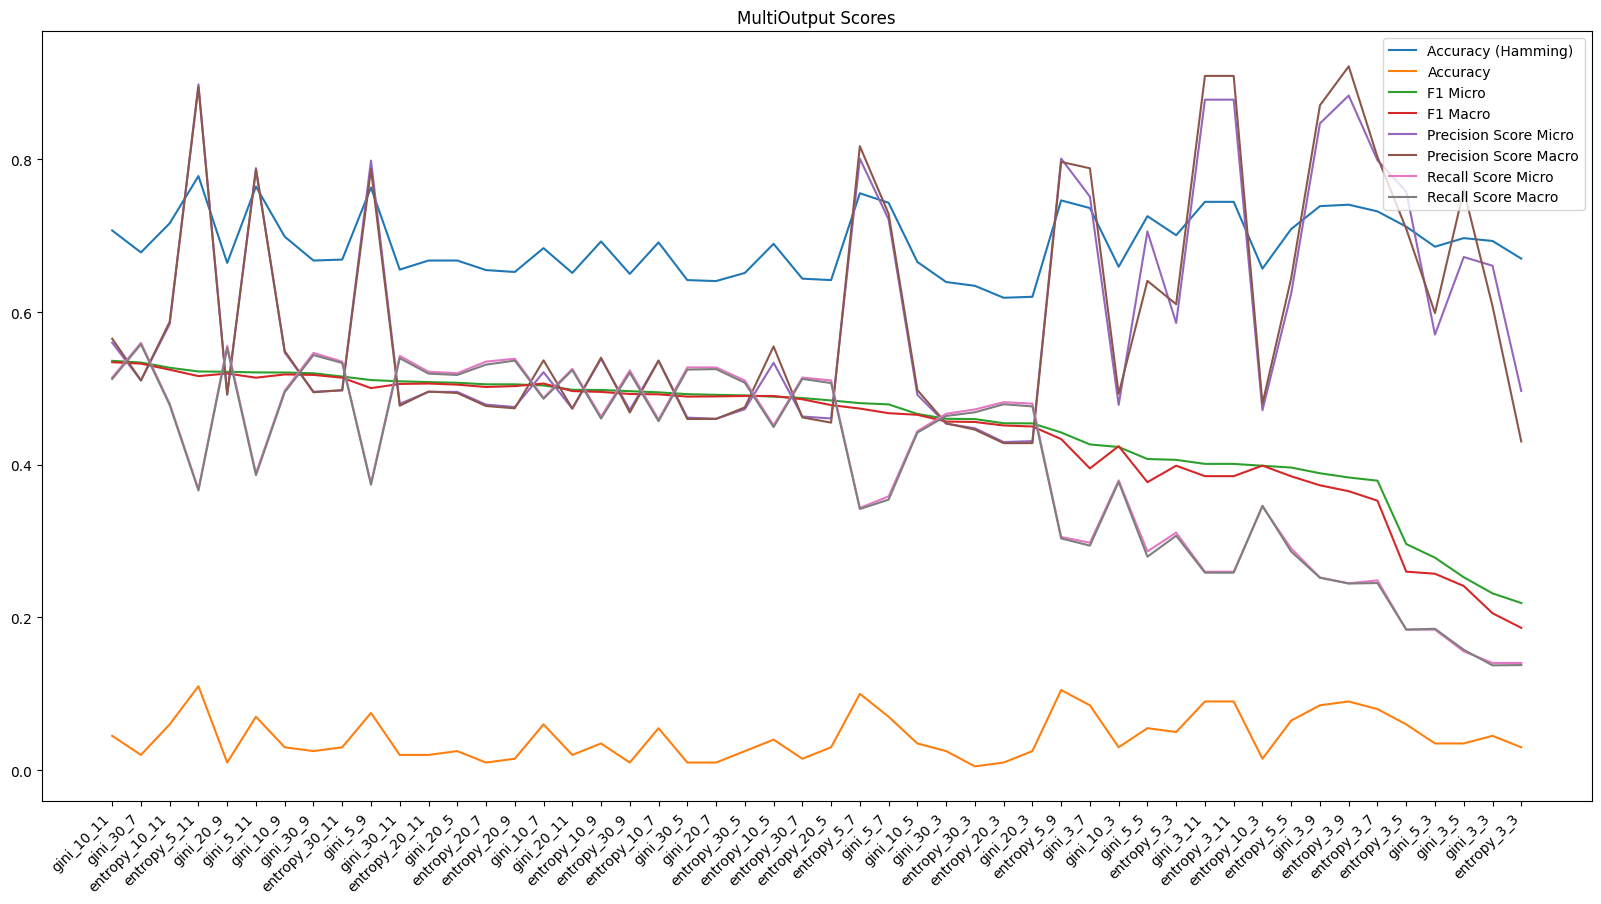

In [206]:
# Plot a graph will all these parameters of scores

x_axis = list(map(lambda x: x[0] + "_" + str(x[1]) + "_" + str(x[2]), all_scores_multioutput))

plt.figure(figsize=(20,10))
plt.title("MultiOutput Scores")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_micro"], all_scores_multioutput)), label="Accuracy (Hamming)")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_macro"], all_scores_multioutput)), label="Accuracy")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_micro"], all_scores_multioutput)), label="F1 Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_macro"], all_scores_multioutput)), label="F1 Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_micro"], all_scores_multioutput)), label="Precision Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_macro"], all_scores_multioutput)), label="Precision Score Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_micro"], all_scores_multioutput)), label="Recall Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_macro"], all_scores_multioutput)), label="Recall Score Macro")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

In [207]:
print("Top 3 Powerset Scores")

pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_powerset[:3]:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

Top 3 Powerset Scores
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |      F1 Macro      | Precision Score Micro | Precision Score Macro | Recall Score Micro | Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
|  entropy  |     5     |      11      | 0.6325000000000001 |   0.09   | 0.6632302405498283 | 0.6366725808222504 |   0.6835891381345927  |   0.6633225993502109  | 0.6440489432703004 |  0.61798207946333  |
|  entropy  |     10    |      9       |        0.61        |   0.02   | 0.6529477196885428 | 0.6374959654350337 |   0.6529477196885428  |   0.637188024551624

In [208]:
print("Top 3 MultiOutput Scores")

pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_multioutput[:3]:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

Top 3 MultiOutput Scores
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+---------------------+--------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |      F1 Macro      | Precision Score Micro | Precision Score Macro |  Recall Score Micro | Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+---------------------+--------------------+
|    gini   |     10    |      11      | 0.7068749999999999 |  0.045   | 0.5361028684470821 | 0.5343124575267539 |   0.5599173553719008  |   0.5651892693316107  |  0.5142314990512334 | 0.5123127704209283 |
|    gini   |     30    |      7       |      0.678125      |   0.02   | 0.5339366515837104 | 0.5324703721504551 |   0.5103806228373703  |   0.51053247

In [209]:
print("Best Powerset Model Confusion Matrix")

print(all_scores_powerset[0][3]["cf_matrix"])

Best Powerset Model Confusion Matrix
[[[ 38  29]
  [ 29 104]]

 [[ 35  29]
  [ 26 110]]

 [[ 42  31]
  [ 31  96]]

 [[ 57  24]
  [ 51  68]]

 [[ 66  35]
  [ 45  54]]

 [[111  22]
  [ 44  23]]

 [[ 42  41]
  [ 50  67]]

 [[ 42  57]
  [ 44  57]]]


In [210]:
print("Best MultiOutput Model Confusion Matrix")

print(all_scores_multioutput[0][3]["cf_matrix"])

Best MultiOutput Model Confusion Matrix
[[[ 95  37]
  [ 31  37]]

 [[115  19]
  [ 32  34]]

 [[ 99  38]
  [ 27  36]]

 [[109  28]
  [ 32  31]]

 [[114  27]
  [ 37  22]]

 [[106  28]
  [ 29  37]]

 [[107  22]
  [ 36  35]]

 [[115  14]
  [ 32  39]]]


In [211]:
kf = KFold(n_splits=k_splits, shuffle=True, random_state=random_state)

# Parameters for the best Powerset Model

criterion_powerset = all_scores_powerset[0][0]
max_depth_powerset = all_scores_powerset[0][1]
max_features_powerset = all_scores_powerset[0][2]

# Parameters for the best MultiOutput Model

criterion_multioutput = all_scores_multioutput[0][0]
max_depth_multioutput = all_scores_multioutput[0][1]
max_features_multioutput = all_scores_multioutput[0][2]

best_powerset_model = DT_Powerset(dataset['labels'], max_depth=max_depth_powerset, max_features=max_features_powerset, criterion=criterion_powerset)
best_multioutput_model = DT_MultiOutput(dataset['labels'], max_depth=max_depth_multioutput, max_features=max_features_multioutput, criterion=criterion_multioutput)

In [212]:
powerset_scores = {
    "accuracy_micro": [],
    "accuracy_macro": [],
    "f1_micro": [],
    "f1_macro": [],
    "precision_score_micro": [],
    "precision_score_macro": [],
    "recall_score_micro": [],
    "recall_score_macro": []
}

multioutput_scores = {
    "accuracy_micro": [],
    "accuracy_macro": [],
    "f1_micro": [],
    "f1_macro": [],
    "precision_score_micro": [],
    "precision_score_macro": [],
    "recall_score_micro": [],
    "recall_score_macro": []
}

for i, (train_index, test_index) in enumerate(kf.split(encoded_data)):
    print("Fold:", i+1)
    y = dataset['labels']

    X_train, X_test = encoded_data.iloc[train_index], encoded_data.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_powerset_model.fit(X_train, y_train)
    best_multioutput_model.fit(X_train, y_train)

    y_pred_powerset = best_powerset_model.predict(X_test)
    y_pred_multioutput = best_multioutput_model.predict(X_test)

    scores_powerset = best_powerset_model.scoring(y_test, y_pred_powerset)
    scores_multioutput = best_multioutput_model.scoring(y_test, y_pred_multioutput)

    del scores_powerset["cf_matrix"]
    del scores_multioutput["cf_matrix"]

    for key in powerset_scores.keys():
        powerset_scores[key].append(scores_powerset[key])
        multioutput_scores[key].append(scores_multioutput[key])

    print("Powerset Scores:", scores_powerset)
    print("MultiOutput Scores:", scores_multioutput)

for key in powerset_scores.keys():
    powerset_scores[key] = np.mean(powerset_scores[key])
    multioutput_scores[key] = np.mean(multioutput_scores[key])

pt = PrettyTable()
pt.field_names = ["Model", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
pt.add_row(["Powerset"] + list(powerset_scores.values()))
pt.add_row(["MultiOutput"] + list(multioutput_scores.values()))
print(pt)


Fold: 1
Powerset Scores: {'accuracy_micro': 0.6325000000000001, 'accuracy_macro': 0.09, 'f1_micro': 0.6632302405498283, 'f1_macro': 0.6366725808222504, 'precision_score_micro': 0.6835891381345927, 'precision_score_macro': 0.6633225993502109, 'recall_score_micro': 0.6440489432703004, 'recall_score_macro': 0.61798207946333}
MultiOutput Scores: {'accuracy_micro': 0.704375, 'accuracy_macro': 0.055, 'f1_micro': 0.5321463897131552, 'f1_macro': 0.5292566020105267, 'precision_score_micro': 0.5557851239669421, 'precision_score_macro': 0.5607919704977529, 'recall_score_micro': 0.5104364326375711, 'recall_score_macro': 0.5074938379939749}
Fold: 2
Powerset Scores: {'accuracy_micro': 0.585, 'accuracy_macro': 0.045, 'f1_micro': 0.6009615384615385, 'f1_macro': 0.5752472079067238, 'precision_score_micro': 0.6361323155216285, 'precision_score_macro': 0.6168673258531269, 'recall_score_micro': 0.5694760820045558, 'recall_score_macro': 0.5473886693841716}
MultiOutput Scores: {'accuracy_micro': 0.69875, 'a